# Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import time

## Start Timer

In [2]:
startTime = time.time()

# Gather Billing Data

In [3]:
filename = '../../002_Data/Release_3/processed_bill.pickle'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()

rows = len(df)
accts = df.SPA_ACCT_ID.nunique()
prems = df.SPA_PREM_ID.nunique()
print(f"Rows: {rows}")
print(f"Accounts: {accts}")
print(f"Premises: {prems}")
print("Grouping")
print(df.groupby(['SPA_ACCT_ID', 'SPA_PREM_ID', 'ARREARSMONTH']).size().value_counts())
df.head()

Rows: 3810352
Accounts: 98054
Premises: 64815
Grouping
1    3810352
dtype: int64


,SPA_ACCT_ID,SPA_PREM_ID,ARREARSMONTH,RES_EL_CUR120_DAYS,RES_EL_CUR22_DAYS,RES_EL_CUR30_DAYS,RES_EL_CUR60_DAYS,RES_EL_CUR90_DAYS,RES_EL_CUR_BAL_AMT,RES_EL_OVER_120_DAYS,...,DUE_DATE,FINAL_NOTICE,PAST_DUE,SEVERANCE_ELECTRIC,SEVERANCE_GAS,CITY_TOT_DUE,CITY_30_DAYS_PAST_DUE_AMT,CITY_60_DAYS_PAST_DUE_AMT,CITY_90_DAYS_PAST_DUE_AMT,COVID_REMINDER
0,6,1557,0,0.0,66.03,0.0,0.0,0.0,66.03,0.0,...,0,0,0,0,0,139.70,0.00,0.0,0.0,0
1,6,1557,1,0.0,61.26,0.0,0.0,0.0,61.26,0.0,...,0,0,0,0,0,246.32,139.70,0.0,0.0,0
2,6,1557,2,0.0,59.74,0.0,0.0,0.0,59.74,0.0,...,0,0,0,0,0,106.37,0.00,0.0,0.0,0
3,6,1557,3,0.0,59.74,0.0,0.0,0.0,59.74,0.0,...,0,0,0,0,0,225.19,0.00,0.0,0.0,0
4,6,1557,4,0.0,52.47,0.0,0.0,0.0,52.47,0.0,...,0,0,0,0,0,243.09,118.82,0.0,0.0,0


# Add Service Agreements Data
Matching on ('SPA_ACCT_ID', 'SPA_PREM_ID')

In [4]:
# NOTE: using release 3 data due to problems with new release

filename = '../../002_Data/Release_3/processed_sa.pickle'
infile = open(filename,'rb')
sa = pickle.load(infile)
infile.close()

sa_rows = len(sa)
sa_accts = sa.SPA_ACCT_ID.nunique()
sa_prems = sa.SPA_PREM_ID.nunique()
sa_ppl = sa.SPA_PER_ID.nunique()
sa_pos = sa[sa.CMIS_MATCH].SPA_PER_ID.nunique()
sa_pos_rows = len(sa[sa.CMIS_MATCH])
print(f"Rows: {sa_rows}")
print(f"Accounts: {sa_accts}")
print(f"Premises: {sa_prems}")
print(f"People: {sa_ppl}")
print(f"P Cases: {sa_pos}")
print(f"P rows: {sa_pos_rows}")
print("Grouping")
print(sa.groupby(['SPA_ACCT_ID', 'SPA_PREM_ID']).size().value_counts())
sa.head()

Rows: 270848
Accounts: 253632
Premises: 148522
People: 243369
P Cases: 1935
P rows: 2072
Grouping
1    270848
dtype: int64


,SPA_ACCT_ID,SPA_PREM_ID,SPA_PER_ID,CMIS_MATCH,APARTMENT,ENROLL_DATE,HAS_COTENANT
0,1,137,90513,False,False,(),True
1,2,36,300687,False,False,(),True
2,3,74902,277858,False,True,(),False
3,4,8,179516,False,False,(),True
4,5,112,237061,False,False,(),False


In [5]:
sa.isnull().sum()

SPA_ACCT_ID     0
SPA_PREM_ID     0
SPA_PER_ID      0
CMIS_MATCH      0
APARTMENT       0
ENROLL_DATE     0
HAS_COTENANT    0
dtype: int64

In [6]:
sa.set_index(['SPA_ACCT_ID', 'SPA_PREM_ID'], inplace=True)
df = df.join(sa, how='left', on=['SPA_ACCT_ID', 'SPA_PREM_ID'])
del sa
df.groupby(['SPA_PER_ID', 'SPA_PREM_ID', 'ARREARSMONTH']).size().value_counts()

1    3358383
2          2
dtype: int64

## Fix Duplicates
Some people at same location, month have multiple accounts. NOTE: None of these are P cases.  
In future, track amount owed relative to billed amount - can just add amount owed and billed amount from both accounts.  
For now, just take first.

In [7]:
df = df.groupby(['SPA_PER_ID', 'SPA_PREM_ID', 'ARREARSMONTH']).first().reset_index()
df.groupby(['SPA_PER_ID', 'SPA_PREM_ID', 'ARREARSMONTH']).size().value_counts()

1    3358385
dtype: int64

In [8]:
df.groupby('SPA_PER_ID')['CMIS_MATCH'].nunique().value_counts()

1    85779
2       24
Name: CMIS_MATCH, dtype: int64

In [9]:
df.SPA_PER_ID.head()

0    1.0
1    1.0
2    3.0
3    3.0
4    3.0
Name: SPA_PER_ID, dtype: float64

In [10]:
print(f"pos rows {len(df[df.CMIS_MATCH])}")
print(f"pos people {df[df.CMIS_MATCH].SPA_PER_ID.nunique()}")
print(f"neg rows {len(df[~df.CMIS_MATCH])}")
print(f"neg people {df[~df.CMIS_MATCH].SPA_PER_ID.nunique()}")

pos_ids = df.groupby('SPA_PER_ID')['CMIS_MATCH'].any()
pos_ids = pos_ids[pos_ids == True].index

df = df.set_index('SPA_PER_ID')
#df.loc[[True for x in df.SPA_PER_ID if x in pos_ids], 'CMIS_MATCH'] = True
df.loc[pos_ids, 'CMIS_MATCH'] = True
df = df.reset_index()

print(f"pos rows {len(df[df.CMIS_MATCH])}")
print(f"pos people {df[df.CMIS_MATCH].SPA_PER_ID.nunique()}")
print(f"neg rows {len(df[~df.CMIS_MATCH])}")
print(f"neg people {df[~df.CMIS_MATCH].SPA_PER_ID.nunique()}")
df.groupby('SPA_PER_ID')['CMIS_MATCH'].nunique().value_counts()

pos rows 8595
pos people 305
neg rows 3349790
neg people 85522
pos rows 9001
pos people 305
neg rows 3349384
neg people 85498


1    85803
Name: CMIS_MATCH, dtype: int64

Now have unique ('SPA_PER_ID', 'SPA_PREM_ID', 'ARREARSMONTH')

# Add Geographical Data
Matching on 'SPA_PREM_ID'

In [11]:
filename = '../../002_Data/Release_4/processed_geo.pickle'
infile = open(filename,'rb')
geo = pickle.load(infile)
infile.close()

geo_rows = len(df)
geo_prems = df.SPA_PREM_ID.nunique()
print(f"Rows: {geo_rows}")
print(f"Premises: {geo_prems}")
print("Grouping")
print(geo.groupby('SPA_PREM_ID').size().value_counts())
geo.head()

Rows: 3358385
Premises: 61030
Grouping
1    155538
dtype: int64


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO,SNAP_GEO,ABOVE_GRD7_GEO,PUBLIC_ASSIST_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163,0.119510,2.499965e-05,0.015322
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921,0.009608,1.000000e+00,0.009608
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392,0.091525,1.000000e+00,0.091525


In [12]:
geo.set_index('SPA_PREM_ID', inplace=True)
df = df.join(geo, how='left', on='SPA_PREM_ID')
del geo
df.groupby(['SPA_PER_ID', 'SPA_PREM_ID', 'ARREARSMONTH']).size().value_counts()

1    3358385
dtype: int64

# Create Additional Attributes

## Billing Aggregation
Avista Electric, Avista Gas, City  
Avista, City  
All

In [13]:
# Avista, City level
df['AVISTA_CUR120_DAYS'] = df['RES_EL_CUR120_DAYS'] + df['RES_GAS_CUR120_DAYS']
df['AVISTA_OVER_120_DAYS'] = df['RES_EL_OVER_120_DAYS'] + df['RES_GAS_OVER_120_DAYS']
df['AVISTA_CUR22_DAYS'] = df['RES_EL_CUR22_DAYS'] + df['RES_GAS_CUR22_DAYS']
df['AVISTA_CUR30_DAYS'] = df['RES_EL_CUR30_DAYS'] + df['RES_GAS_CUR30_DAYS']
df['AVISTA_CUR60_DAYS'] = df['RES_EL_CUR60_DAYS'] + df['RES_GAS_CUR60_DAYS']
df['AVISTA_CUR90_DAYS'] = df['RES_EL_CUR90_DAYS'] + df['RES_GAS_CUR90_DAYS']
df['AVISTA_CUR_BAL_AMT'] = df['RES_EL_CUR_BAL_AMT'] + df['RES_GAS_CUR_BAL_AMT']

# All
df['TOTAL_30_DAYS_AMT'] = df['CITY_30_DAYS_PAST_DUE_AMT'] + df['AVISTA_CUR30_DAYS']
df['TOTAL_60_DAYS_AMT'] = df['CITY_60_DAYS_PAST_DUE_AMT'] + df['AVISTA_CUR60_DAYS']
df['TOTAL_90_DAYS_AMT'] = df['CITY_90_DAYS_PAST_DUE_AMT'] + df['AVISTA_CUR90_DAYS']
df['TOTAL_CUR_BALANCE'] = df['AVISTA_CUR_BAL_AMT'] + df['CITY_TOT_DUE']

## Generate Different Outcome Measures
### LAST_MO_W_DATA
Last month with data on positive cases - estimate of when person started experiencing homelessness  
If have multiple ENROLL_DATEs, choose last month for each  
### 6_MO_PRIOR
Within 6 months of last data month before experiencing homelessness?
### MO_AWAY
Number of months away from experiencing homelessness

In [14]:
def get_outcomes(df):
    '''
    05/14/21
    Creates
        'LAST_MO_W_DATA' - boolean if P and last month with data
        'WITHIN_6_MO_PRIOR_LAST_DATA' - boolean if P and within 6 mo of last data
    '''
    new_df = df.copy()
    lasts = new_df[new_df.CMIS_MATCH].groupby(['SPA_PER_ID']).last()[['SPA_PREM_ID', 'ARREARSMONTH']]
    lasts['LAST_MO_W_DATA'] = lasts['ARREARSMONTH']
    lasts = lasts.reset_index().set_index(['SPA_PER_ID', 'SPA_PREM_ID']).drop('ARREARSMONTH', axis=1)
    new_df = new_df.join(lasts, on=['SPA_PER_ID', 'SPA_PREM_ID'], how='left')
    # Create WITHIN_6_MO_PRIOR_LAST_DATA
    new_df['WITHIN_6_MO_PRIOR_LAST_DATA'] = (new_df['ARREARSMONTH'] >= (new_df['LAST_MO_W_DATA'] - 6))
    # Create MO_AWAY
    new_df['MO_AWAY'] = new_df['LAST_MO_W_DATA'] - new_df['ARREARSMONTH']
    # Change 'LAST_MO_W_DATA' to boolean
    new_df['LAST_MO_W_DATA'] = (new_df['LAST_MO_W_DATA'] == new_df['ARREARSMONTH']).replace(to_replace=np.nan, value=False).astype('bool')
    return new_df

In [15]:
df = get_outcomes(df)

<AxesSubplot:>

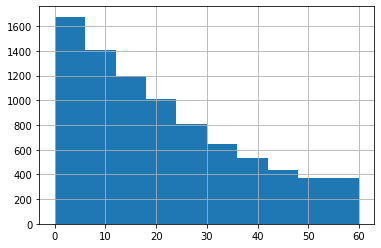

In [16]:
df.MO_AWAY.hist()

In [17]:
df.MO_AWAY.max()

60.0

In [18]:
df.MO_AWAY = df.MO_AWAY.replace(to_replace=np.nan, value=100)

## People and Premises
* 'NUM_SPA_PER_ID_FOR_SPA_PREM_ID': number of people for each premises  
* 'NUM_SPA_PREM_ID_FOR_SPA_PER_ID': number of premises for each person

In [19]:
def accumulate(df, grp_by_col, cumulative_col, new_col_name):
    '''
    05/02/21
    Finds cumulative counts.
    '''
    month_col = 'ARREARSMONTH'
    cumulative = df[[month_col, grp_by_col, cumulative_col]].copy()
    # Find number of unique cumulateive elements
    cumulative = cumulative.drop_duplicates([grp_by_col, cumulative_col], keep='first').groupby([grp_by_col, month_col]).nunique()
    # Find cumulative count of unique elements
    cumulative[new_col_name] = (cumulative.groupby(grp_by_col)[cumulative_col].cumcount() + 1).astype('int64')
    cumulative.drop(cumulative_col, axis=1, inplace=True)
    # Join counts back to df
    new_df = df.join(cumulative, how='left', on=[grp_by_col, month_col])
    # Forward fill index gaps
    new_df[new_col_name].ffill(inplace=True)
    return new_df

In [20]:
# Determine cumulative number of places a person has paid bills at so far
df = accumulate(df, grp_by_col='SPA_PER_ID', cumulative_col='SPA_PREM_ID', new_col_name='NUM_PREM_FOR_PER')

# Determine cumulative number of people a premesis has seen so far
df = accumulate(df, grp_by_col='SPA_PREM_ID', cumulative_col='SPA_PER_ID', new_col_name='NUM_PER_FOR_PREM')

## Size of MultiUnit
number of SPA_PREM_ID's at same MULTI_DWELL_ID

In [21]:
multi_dwell_size = df.groupby('MULTI_DWELL_ID').SPA_PREM_ID.nunique().rename('MULTI_DWELL_SIZE')
# Set size for not multi_unit to 0 
multi_dwell_size.loc[-1.0] = 0
df = df.join(multi_dwell_size, how='left', on='MULTI_DWELL_ID')

# Check NANs and Infs

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
df.isnull().sum()

SPA_PER_ID                         0
SPA_PREM_ID                        0
ARREARSMONTH                       0
SPA_ACCT_ID                        0
RES_EL_CUR120_DAYS                 0
RES_EL_CUR22_DAYS                  0
RES_EL_CUR30_DAYS                  0
RES_EL_CUR60_DAYS                  0
RES_EL_CUR90_DAYS                  0
RES_EL_CUR_BAL_AMT                 0
RES_EL_OVER_120_DAYS               0
RES_GAS_CUR120_DAYS                0
RES_GAS_CUR22_DAYS                 0
RES_GAS_CUR30_DAYS                 0
RES_GAS_CUR60_DAYS                 0
RES_GAS_CUR90_DAYS                 0
RES_GAS_CUR_BAL_AMT                0
RES_GAS_OVER_120_DAYS              0
BREAK_ARRANGEMENT                  0
BREAK_PAY_PLAN                     0
CALL_OUT                           0
CALL_OUT_MANUAL                    0
DUE_DATE                           0
FINAL_NOTICE                       0
PAST_DUE                           0
SEVERANCE_ELECTRIC                 0
SEVERANCE_GAS                      0
C

## Drop All Rows w/NaNs in Geographical Attributes
This only drops 4 Positive cases

In [24]:
df[df['POSTAL'].isnull() & df['CMIS_MATCH']]['SPA_PER_ID'].nunique()

3

In [25]:
print(f"Rows: {len(df)}")
print(f"Accounts: {df.SPA_ACCT_ID.nunique()}")
print(f"Premises: {df.SPA_PREM_ID.nunique()}")

df = df[~df['POSTAL'].isnull()]

print()
print(f"Rows: {len(df)}")
print(f"Accounts: {df.SPA_ACCT_ID.nunique()}")
print(f"Premises: {df.SPA_PREM_ID.nunique()}")

df.isnull().sum()

Rows: 3358385
Accounts: 86750
Premises: 61030

Rows: 3346276
Accounts: 86432
Premises: 60785


SPA_PER_ID                     0
SPA_PREM_ID                    0
ARREARSMONTH                   0
SPA_ACCT_ID                    0
RES_EL_CUR120_DAYS             0
RES_EL_CUR22_DAYS              0
RES_EL_CUR30_DAYS              0
RES_EL_CUR60_DAYS              0
RES_EL_CUR90_DAYS              0
RES_EL_CUR_BAL_AMT             0
RES_EL_OVER_120_DAYS           0
RES_GAS_CUR120_DAYS            0
RES_GAS_CUR22_DAYS             0
RES_GAS_CUR30_DAYS             0
RES_GAS_CUR60_DAYS             0
RES_GAS_CUR90_DAYS             0
RES_GAS_CUR_BAL_AMT            0
RES_GAS_OVER_120_DAYS          0
BREAK_ARRANGEMENT              0
BREAK_PAY_PLAN                 0
CALL_OUT                       0
CALL_OUT_MANUAL                0
DUE_DATE                       0
FINAL_NOTICE                   0
PAST_DUE                       0
SEVERANCE_ELECTRIC             0
SEVERANCE_GAS                  0
CITY_TOT_DUE                   0
CITY_30_DAYS_PAST_DUE_AMT      0
CITY_60_DAYS_PAST_DUE_AMT      0
CITY_90_DA

# Update Attribute Types

In [26]:
df.dtypes

SPA_PER_ID                     float64
SPA_PREM_ID                      int64
ARREARSMONTH                     int64
SPA_ACCT_ID                      int64
RES_EL_CUR120_DAYS             float64
RES_EL_CUR22_DAYS              float64
RES_EL_CUR30_DAYS              float64
RES_EL_CUR60_DAYS              float64
RES_EL_CUR90_DAYS              float64
RES_EL_CUR_BAL_AMT             float64
RES_EL_OVER_120_DAYS           float64
RES_GAS_CUR120_DAYS            float64
RES_GAS_CUR22_DAYS             float64
RES_GAS_CUR30_DAYS             float64
RES_GAS_CUR60_DAYS             float64
RES_GAS_CUR90_DAYS             float64
RES_GAS_CUR_BAL_AMT            float64
RES_GAS_OVER_120_DAYS          float64
BREAK_ARRANGEMENT                int64
BREAK_PAY_PLAN                   int64
CALL_OUT                         int64
CALL_OUT_MANUAL                  int64
DUE_DATE                         int64
FINAL_NOTICE                     int64
PAST_DUE                         int64
SEVERANCE_ELECTRIC       

In [27]:
to_ints = [
    'SPA_PER_ID',
    'POSTAL',
    'AGG_INCOME_GEO',
    'NUM_PREM_FOR_PER',
    'NUM_PER_FOR_PREM',
    'BLOCKGROUP_GEOID',
    'MULTI_DWELL_ID',
    'MULTI_DWELL_SIZE',
    'MO_AWAY'
]
for col in to_ints:
    df[col] = df[col].astype('int64')

df.dtypes

SPA_PER_ID                       int64
SPA_PREM_ID                      int64
ARREARSMONTH                     int64
SPA_ACCT_ID                      int64
RES_EL_CUR120_DAYS             float64
RES_EL_CUR22_DAYS              float64
RES_EL_CUR30_DAYS              float64
RES_EL_CUR60_DAYS              float64
RES_EL_CUR90_DAYS              float64
RES_EL_CUR_BAL_AMT             float64
RES_EL_OVER_120_DAYS           float64
RES_GAS_CUR120_DAYS            float64
RES_GAS_CUR22_DAYS             float64
RES_GAS_CUR30_DAYS             float64
RES_GAS_CUR60_DAYS             float64
RES_GAS_CUR90_DAYS             float64
RES_GAS_CUR_BAL_AMT            float64
RES_GAS_OVER_120_DAYS          float64
BREAK_ARRANGEMENT                int64
BREAK_PAY_PLAN                   int64
CALL_OUT                         int64
CALL_OUT_MANUAL                  int64
DUE_DATE                         int64
FINAL_NOTICE                     int64
PAST_DUE                         int64
SEVERANCE_ELECTRIC       

# Save + Stats + Time

In [29]:
filename = '../../002_Data/Release_4/data_combined.pickle'
outfile = open(filename, 'wb')
pickle.dump(df, outfile)
outfile.close()

## Matching Stats

In [28]:
retained_rows = len(df)
retained_p = df[df.CMIS_MATCH]['SPA_PER_ID'].nunique()
retained_ppl = df.SPA_PER_ID.nunique()
retained_p_rows = len(df[df.CMIS_MATCH])
retained_prems = df.SPA_PREM_ID.nunique()

print(f'Retained {retained_rows} = {round(100*retained_rows/rows, ndigits=2)}% rows.')
print(f'Retained {retained_ppl} = {round(100*retained_ppl/sa_ppl, ndigits=2)}% people.')
print(f'Retained {retained_p} = {round(100*retained_p/sa_pos, ndigits=2)}% positive cases.')
print(f'Retained {retained_p_rows} = {round(100*retained_p_rows/sa_pos_rows, ndigits=2)}% positive rows.')
print(f'Retained {retained_prems} = {round(100*retained_prems/geo_prems, ndigits=2)}% premises.')

Retained 3346276 = 87.82% rows.
Retained 85494 = 35.13% people.
Retained 302 = 15.61% positive cases.
Retained 8946 = 431.76% positive rows.
Retained 60785 = 99.6% premises.


## Total Time

In [57]:
from custom_methods.calc_time import calc_time_from_sec

calc_time_from_sec(time.time()-startTime)

hours:minutes:seconds = 0:1:1.4668912887573242
